# Controlling Neural Networks with Rule Representations
## This notebook is derived from this paper by Seo et al.
https://arxiv.org/pdf/2106.07804.pdf

## Summary:
In this notebook we will apply the Rule Representation to the prediction of the next state of a double pendulum sistem.

This is a dummy task to test if our knoweledge of a physical phenomenon can help a model to learn better reppresentation while solving a problem with a "data driven apprach".

We will first simulate the motion of a duble pendulum with friction and then build a loss function for the model that leverage the information that friction is a non-conservative force so work done against friction is path dependent and in the presence of friction, some kinetic energy is always transformed to thermal energy, so **mechanical energy is not conserved.** (Our Rule, from now on)

$$
E(t+1) < E(t)
$$

We will compare this model with a naive approch that learn the dynamic only from the data and we will observe if the physical constrain above is respected.

In particular, we will use **DeepCTRL** a framework developed by Seo et al. at Google Cloud AI that will allow the model to learn representation for the Rule and the Task separately and those representation can be merged at inference time to set the strength of the physical contrain that we want to apply to the model prediction.

The double pendulum problem can be found on Wikipedia https://en.wikipedia.org/wiki/Double_pendulum

### Parameter of the experiment
#### Pendulum
L1 : Rod length 1, M1 : Mass 1
L2 : Rod length 2, M2 : Mass 2

Friction coefficients F1, F2

#### Initial condition for the  angles $\theta_1$ and  $\theta_2$ of the two pendulums are randomly sampled. Initial velocity is zero

![pendulum image](https://upload.wikimedia.org/wikipedia/commons/7/78/Double-Pendulum.svg )
#### Paramenter for the simulation
delta_t : time step for the simulation
tmax : max time

![pendulum gif](https://upload.wikimedia.org/wikipedia/commons/4/45/Double-compound-pendulum.gif )


Motion of the double compound pendulum (from numerical integration of the equations of motion)

Motion is simulated with friction so the oscillations damp over time

In [1]:
from __future__ import division
from __future__ import print_function

import sys
import os
import random


import numpy as np
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset
from torch.distributions.beta import Beta

from utils_dp import DoublePendulum, calc_double_E, verification



model_info = {
              'paper': {'beta': [0.1], 'scale': 0, 'shared': True}, # Parameter used in the paper
             }

if not (os.path.exists("saved_models/")):# create a save folder if it doesn't exist 
    os.makedirs("saved_models")
    print("created saved_model folder")

In [2]:
L1, L2, M1, M2, F1, F2 = 1, 1, 1, 5, 0.001, 0.001
    
init_theta1 = 0.3 #round(np.random.uniform(-np.pi/4, np.pi/4), 4)
init_omega1 = 0.1
init_theta2 = -0.1#round(np.random.uniform(-np.pi/4, np.pi/4), 4)
init_omega2 = -0.1

tmax, dt = 3000, 0.005 # dt is the small time step used for simulation

dp = DoublePendulum(L1, L2, M1, M2, init_theta1, init_omega1, init_theta2, init_omega2, F1, F2)

device = 'cuda:0'
seed = 42

# task paramenters
std_noise = 0.02  # noise added to trajectories# A large paramente makes the task harder--> training trajectories are noisier
sampling_step = 30    # sample a row for every the step. # A large parameter makes the task more difficult--> prediction of the state after a longer time gap

In [3]:
t, y = dp.generate(tmax=tmax, dt=dt)# Double pendulum simulation from the equations of motion

dp_params = {'M1': dp.M1, 'M2': dp.M2, 'L1': dp.L1, 'L2': dp.L2, 'g': dp.g, 'F1': dp.F1, 'F2': dp.F2}
print('sequence length: {} ({} sec)'.format(len(y), tmax))
print('dt: {} (sec)\n'.format(dt))

Length (L1,L2), Mass (M1,M2), and Friction (F1,F2) of a string: (1,1) (1,5), (0.001,0.001)
Initial theta(degree): 0.300000(17.188734),-0.100000(-5.729578)
Initial omega: 0.100000,-0.100000
sequence length: 600001 (3000 sec)
dt: 0.005 (sec)



Text(0.5, 1.0, 'Energy of the sistem (with friction)')

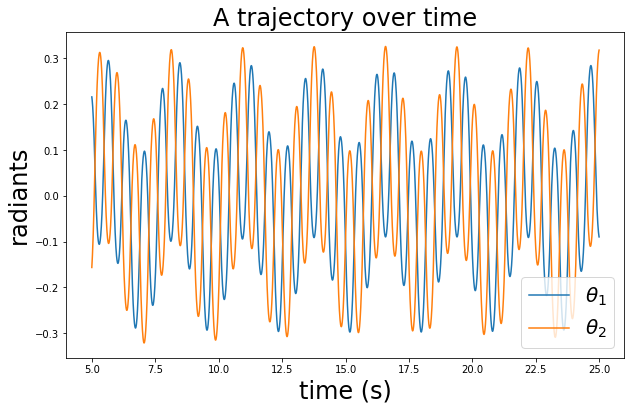

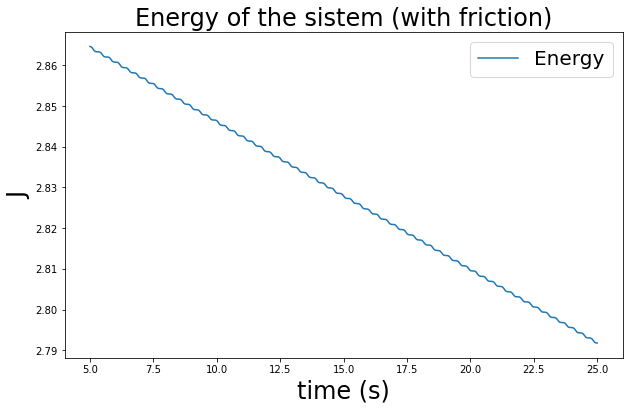

In [4]:
x_time = np.arange(y.shape[0])*dt
fig, ax = plt.subplots(figsize=[10, 6])
ax.plot(x_time[1000:5000],y[1000:5000,0],label = r"$\theta_1$")
ax.plot(x_time[1000:5000],y[1000:5000,2],label = r"$\theta_2$")
plt.legend(fontsize=20)
ax.set_ylabel('radiants', fontsize=24)
ax.set_xlabel('time (s)', fontsize=24)
plt.title("A trajectory over time",fontsize=24)

_, _, pred_E = calc_double_E(y[1000:5000,:], **dp_params) 

fig, ax = plt.subplots(figsize=[10, 6])
ax.plot(x_time[1000:5000],pred_E,label = r"Energy")

plt.legend(fontsize=20)
ax.set_ylabel('J', fontsize=24)
ax.set_xlabel('time (s)', fontsize=24)
plt.title("Energy of the sistem (with friction)",fontsize=24)

In [5]:
# Fine dt for generation and subsample for learning

sampling_dt = dt*sampling_step
sampling_ind = np.arange(0, t.shape[0] - 1, sampling_step)
sampling_t = t[sampling_ind]

input_output_y = np.concatenate((y[:-1], y[1:]), axis=1)    # [[input, output]]
X = input_output_y[sampling_ind]
print('subsampled sequence length: {} ({} sec)'.format(len(X), tmax))
print('sampling dt: {} (sec)'.format(sampling_dt))

subsampled sequence length: 20000 (3000 sec)
sampling dt: 0.15 (sec)


## Dataset generation:
Data is simulated with a small dt and then subsampled to obtain the trainig/test set

Text(0.5, 1.0, 'Subsampled trajectories')

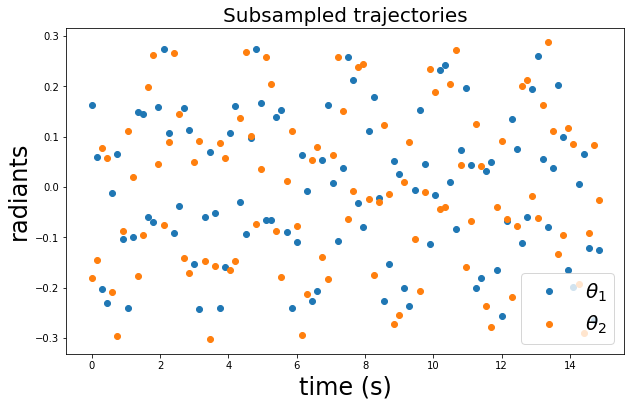

In [6]:
fig, ax = plt.subplots(figsize=[10, 6])
ax.plot( np.arange(X[1000:1100,0].shape[0])*sampling_dt,X[1000:1100,0],"o",label = r"$\theta_1$")
ax.plot( np.arange(X[1000:1100,0].shape[0])*sampling_dt,X[1000:1100,2],"o",label = r"$\theta_2$")
plt.legend(fontsize=20)
ax.set_ylabel('radiants', fontsize=24)
ax.set_xlabel('time (s)', fontsize=24)
plt.title("Subsampled trajectories",fontsize=20)

In [7]:
# Data preprocessing
X = torch.tensor(np.array(X), dtype=torch.float32, device=device)# loaded on the GPU. Be carful when the dataset is not that small
num_samples = X.shape[0]
input_dim = X.shape[1]//2    # (theta1, omega1, theta2, omega2)

# 60:10:30 split
train_X, train_y = X[:int(num_samples*0.6), :input_dim], X[:int(num_samples*0.6), input_dim:]
valid_X, valid_y = X[int(num_samples*0.6):int(num_samples*0.7), :input_dim], X[int(num_samples*0.6):int(num_samples*0.7), input_dim:]
test_X, test_y = X[int(num_samples*0.7):, :input_dim], X[int(num_samples*0.7):, input_dim:]

In [8]:
total_train_sample = len(train_X)
total_valid_sample = len(valid_X)
total_test_sample = len(test_X)

batch_size = 64
train_loader = DataLoader(TensorDataset(train_X, train_y), batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(TensorDataset(valid_X, valid_y), batch_size=valid_X.shape[0])
test_loader = DataLoader(TensorDataset(test_X, test_y), batch_size=test_X.shape[0])

print("data size: {}/{}/{}".format(len(train_X), len(valid_X), len(test_X)))

data size: 12000/2000/6000


In [9]:
# Start
model_type = "paper"
if model_type not in model_info:
    lr = 0.001
    shared = False
    constraint = 0.0
    scale = 1.0
    beta_param = [1.0]
    alpha_distribution = Beta(float(beta_param[0]), float(beta_param[0]))
    model_params = {}

else:
    model_params = model_info[model_type]
    lr = model_params['lr'] if 'lr' in model_params else 0.001
    shared = model_params['shared'] if 'shared' in model_params else False
    constraint = model_params['constraint'] if 'constraint' in model_params else 0.0
    scale = model_params['scale'] if 'scale' in model_params else 1.0
    beta_param = model_params['beta'] if 'beta' in model_params else [1.0]
    if len(beta_param) == 1:
          alpha_distribution = Beta(float(beta_param[0]), float(beta_param[0]))
    elif len(beta_param) == 2:
          alpha_distribution = Beta(float(beta_param[0]), float(beta_param[1]))

print('model_type: {}\tscale:{}\tBeta distribution: Beta({})\tlr: {}, constraint: {}, seed: {}'
    .format(model_type, scale, beta_param, lr, constraint, seed))


model_type: paper	scale:0	Beta distribution: Beta([0.1])	lr: 0.001, constraint: 0.0, seed: 42


In [10]:
test_distribution = alpha_distribution.sample([10000]).cpu().numpy()

Text(0.5, 1.0, 'Symmetric Beta distribution with shape parameters = 0.1\n $\\alpha$ is sampled from this distribution ')

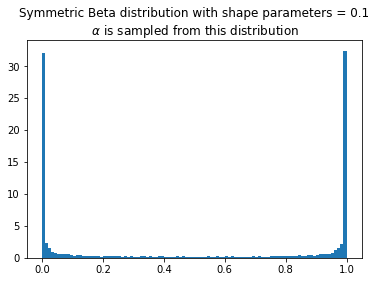

In [11]:
_ =plt.hist(test_distribution,100,density=True)
plt.title("Symmetric Beta distribution with shape parameters = 0.1\n"+r" $\alpha$ is sampled from this distribution ")

In [12]:
# seed to help reproducibility. Please use a fixed initial condition per the pendulum or save the dataset
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Model definition:
![model paper](https://blogger.googleusercontent.com/img/a/AVvXsEjRfAlJh0f8_h3PW99VyUau4Tg-nqiUUqIG9v03AZq06JCFmk_--CgtSGHdfSuDj56qJe6jDuB5DKRMqaDhiup2VFzbNYhDZLOD5VthvyxGP1fjx3240uyzrPiKm18W-Atzxej44GoGYRsrr9-M77-nVOWRHl0tU_Nxsell3UArFd8OTS-Uqikt5f_WZw=w640-h188)

DeepCTRL pairs a data encoder and rule encoder, which produce two latent representations, which are coupled with corresponding objectives. The control parameter α is adjustable at inference to control the relative weight of each encoder.

### for this task we will need:
- A shared input layer
- A simple MLP as the Data encoder
- A simple MLP as the Rule encoder

- A concatenate operation to merge the two representations
- A shared decision block (another MLP) to combine the two representations and provide a prediction


The Task and Rule representation ($z_t$ and $z_r$) are not forced as two separate network but instead they are stochastically combined  with the control parameters $\alpha$. 

Task and Rule encoder can be very different. In particular for many tasks the Task encoder may have a complex architecture while the Rule encoder may be more shallow.

the two representations are stochastically concatenated  to obtain a single representation z. To adjust the relative contributions of Task vs. Rule encoding, a random parameter $\alpha \in [0, 1]$ is used, which also couples $(z_t, z_r)$ with the corresponding objectives $(L_{task}, L_{rule})$. 
$\alpha$ is sampled from the distribution $P (\alpha)$. The motivation to use a random α is to encourage learning the mapping with a range of values, so that at inference, the model can yield high performance with any particular chosen value. The output of the decision block ( y) is used in the entire objective.

Since we want to chage the behaviour of the model whene the $\alpha$ parameter is changend and we want to specialize the representation of the two encoders $\alpha$ is sampled froma Beta distriburion with equal shape parameters < 1.
This distribution is strongly peaked at 0 and 1.

https://en.wikipedia.org/wiki/Beta_distribution#Symmetric_(%CE%B1_=_%CE%B2)

In [13]:
#   input_dim = 4
input_dim_encoder = 16
output_dim_encoder = 64
hidden_dim_encoder = 64
hidden_dim_db = 64
output_dim = input_dim
n_layers = 2

In [14]:
# A simple MLP for the extraction of the Rule representation
class RuleEncoder(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=4):
        super(RuleEncoder, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.net = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                 nn.ReLU(),
                                 nn.Linear(hidden_dim, hidden_dim),
                                 nn.ReLU(),
                                 nn.Linear(hidden_dim, output_dim)
                                )

    def forward(self, x):
        return self.net(x)

# A simple MLP for the extraction of the Task representation
class DataEncoder(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=4):
        super(DataEncoder, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.net = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                 nn.ReLU(),
                                 nn.Linear(hidden_dim, hidden_dim),
                                 nn.ReLU(),
                                 nn.Linear(hidden_dim, output_dim)
                                )

    def forward(self, x):
        return self.net(x)



class DeepCTRL(nn.Module):
    def __init__(self, input_dim, output_dim, rule_encoder, data_encoder, hidden_dim=4, n_layers=2):
        super(DeepCTRL, self).__init__()
        
        
        self.rule_encoder = rule_encoder
        self.data_encoder = data_encoder
        
        self.n_layers = n_layers
        assert self.rule_encoder.input_dim ==  self.data_encoder.input_dim
        assert self.rule_encoder.output_dim ==  self.data_encoder.output_dim
        
        
        self.input_dim_decision_block = self.rule_encoder.output_dim * 2
        
        # A shared input network.
        self.shared_net = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                        nn.ReLU(),
                                        nn.Linear(hidden_dim, self.rule_encoder.input_dim))
        
        # A copy of the shared net to test a configuration with non shared first layers.
        self.shared_net2 = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                        nn.ReLU(),
                                        nn.Linear(hidden_dim, self.rule_encoder.input_dim))
        # A shared output network
        self.net = []
        
        for i in range(n_layers):
            if i == 0:
                in_dim = self.input_dim_decision_block
            else:
                in_dim = hidden_dim

            if i == n_layers-1:
                out_dim = output_dim
            else:
                out_dim = hidden_dim

            self.net.append(nn.Linear(in_dim, out_dim))
            if i != n_layers-1:
                self.net.append(nn.ReLU())

        self.net = nn.Sequential(*self.net)

    def get_z(self, x, alpha=0.0):# To explore the dual representation space
        out1 = self.shared_net(x)
        out2 = self.shared_net2(x)
        rule_z = self.rule_encoder(out1)
        data_z = self.data_encoder(out2)
        
        #out = self.shared_net(x)
        #rule_z = self.rule_encoder(out)
        #data_z = self.data_encoder(out)

        
    
        z = torch.cat((alpha*rule_z, (1-alpha)*data_z), dim=-1)    # merge: Concat
      
        return z

    def forward(self, x, alpha=0.0):# the "call" function. 
        # merge: cat 
        out1 = self.shared_net(x)
        out2 = self.shared_net2(x)
        rule_z = self.rule_encoder(out1)
        data_z = self.data_encoder(out2)
        
        #out = self.shared_net(x)
        #rule_z = self.rule_encoder(out)
        #data_z = self.data_encoder(out)

        z = torch.cat((alpha*rule_z, (1-alpha)*data_z), dim=-1)    # merge: Concat
        
        return self.net(z) + x    # predict delta values
   


In [15]:
rule_encoder = RuleEncoder(input_dim_encoder, output_dim_encoder, hidden_dim=hidden_dim_encoder)
data_encoder = DataEncoder(input_dim_encoder, output_dim_encoder, hidden_dim=hidden_dim_encoder)
model = DeepCTRL(input_dim, output_dim, rule_encoder, data_encoder, hidden_dim=hidden_dim_db, n_layers=n_layers).to(device)

In [16]:
total_params = sum(p.numel() for p in model.parameters())
print("total parameters: {}".format(total_params))

total parameters: 30052


In [17]:
loss_rule_func = lambda x,y: torch.mean(F.relu(x-y))    # if x>y, penalize it.
loss_task_func = nn.L1Loss()    # return scalar (reduction=mean)
l1_func = nn.L1Loss()
best_val_loss = float('inf')
optimizer = optim.Adam(model.parameters(), lr=lr)

In [18]:
epochnum = 500
early_stopping_thld = 10
counter_early_stopping = 1
valid_freq = 5
saved_filename = 'dp-{}_{:.4f}_{:.1f}_{:.4f}_{:.1f}-seed{}.skip.demo.pt' \
                      .format(model_type, init_theta1, init_omega1, init_theta2, init_omega2, seed)

saved_filename =  os.path.join('saved_models', saved_filename)
print('saved_filename: {}\n'.format(saved_filename))

saved_filename: saved_models/dp-paper_0.3000_0.1_-0.1000_-0.1-seed42.skip.demo.pt



## The network task
The task is to predict the state $(\theta_1,\theta_2,\omega_1,\omega_2)$ of the system at time $(t + \Delta t)$ give the state at time $t$. With standard paramenters $\Delta t$ is 0.1 s so 20 times larger than the $dt$ used for the simulation.
A visualization of a traing batch will follow

Text(0.5, 1.0, 'Subsampled trajectories')

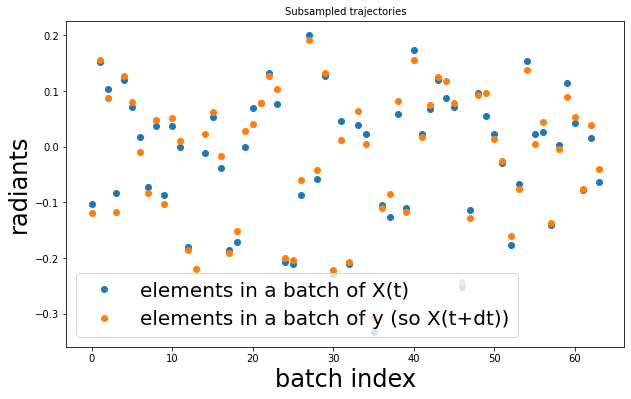

In [19]:

batch_train_x,batch_train_y = next(iter(train_loader))
fig, ax = plt.subplots(figsize=[10, 6])
ax.plot(batch_train_x.cpu().numpy()[:,2] + std_noise*np.random.randn(batch_train_x.shape[0]),'o',label="elements in a batch of X(t)")
ax.plot(batch_train_y.cpu().numpy()[:,2],'o',label="elements in a batch of y (so X(t+dt))")



plt.legend(fontsize=20)
ax.set_ylabel('radiants', fontsize=24)
ax.set_xlabel('batch index', fontsize=24)
plt.title("Subsampled trajectories",fontsize=10)

## Training loop 
### At each epoch (one iteration over the whole dataset)
### The dataset is divided in mini-batches,at each step we compute the loss and update the wegths for the corrisponding data batch . So for each Step:

- data is loaded as a batch
- gradients are resetted calling optimizer.zero_grad(). If this function is not called we accumulate gradients from all the calls to loss.backward()

To utilize the **Rule Representation** we also need: 

- alpha $(\alpha)$ (the rule strength) is sampled from a beta distribution
- Energy is computed (mechanical energy of the double pendulum)

With the output and the targets we can compute the loss for the task:
- Model is called to predict outputs for the current batch (forward pass)
- "Loss Task" $L_{T}$ is computed (this loss depends only on the data provided for the batch)
- "Loss Rule" $L_{R}$ is computed (this loss depends only on our knoweledge of the physics involved)

For a naive model, the total loss $L_{total}$ would be the sum of $L_{T}$ and $L_{R}$ weigthed with a fixed contrain $\lambda$

$$
L_{total} = L_{T} + \lambda*L_{R}
$$

Instead this model is trained with a varing weigth $\alpha$ that is sampled from a given distribution at each step. Moreover a scale parameter $s$ is dinamically computed  to keep $L_{T}$ and $L_{R}$ of the same order of magnitude.


$$
L_{total} = \alpha * L_{T} + s * (1-\alpha)*L_{R}
$$

With $s =  L_{R}/ L_{T} $

With the loss we can now:
- compute the the derivative of the loss w.r.t. the parameters ("the gradients") using backpropagation calling loss.backward()
- call optimizer.step() to make a step based on the gradients 

In [20]:
# Training
ADJ_SCALE=False
for epoch in range(1, epochnum+1):
    model.train()
    for batch_idx, batch_data in enumerate(train_loader):
        batch_train_x = batch_data[0] + std_noise*torch.randn(batch_data[0].shape).to(device)    # Adding noise
        batch_train_y = batch_data[1]

        optimizer.zero_grad() # Clears old gradient from last step. If this function is not called you would accumulate gradients from all the calls loss.backward()
    

 
        alpha = alpha_distribution.sample().item()

        output = model(batch_train_x, alpha=alpha)

        _, _, curr_E = calc_double_E(batch_train_x, **dp_params)    # E(X_t)    Energy of X_t (Current energy)
        _, _, next_E = calc_double_E(batch_train_y, **dp_params)    # E(X_{t+1})    Energy of X_{t+1} (Next energy from ground truth)
        _, _, pred_E = calc_double_E(output, **dp_params)    # E(\hat{X}_t+1)    Energy of \hat{X}_{t+1} (Next energy from prediction)

        loss_task = loss_task_func(output, batch_train_y)    # state prediction
        loss_rule = loss_rule_func(pred_E, curr_E)    # energy damping by friction: E_{t+1}<=E_t
        loss_mae = l1_func(output, batch_train_y).item()

        if True:# epoch>5:
            if scale == 0:
                scale = loss_rule.item() / loss_task.item()
                print('scale is updated: {}'.format(scale))
        
        loss = alpha * loss_rule + scale * (1-alpha) * loss_task

        loss.backward()
        optimizer.step()

# Evaluate on validation set
    if epoch % valid_freq == 0:
        model.eval()
        with torch.no_grad():
            val_loss_task = 0
            val_loss_rule = 0
            val_ratio = 0
            for val_x, val_y in valid_loader:
                val_x += 0.01*torch.randn(val_x.shape).to(device)
                output = model(val_x, alpha=0.0)
                _, _, curr_E = calc_double_E(val_x, **dp_params)
                _, _, pred_E = calc_double_E(output, **dp_params)

                val_loss_task += (loss_task_func(output, val_y).item() * val_x.shape[0] / total_valid_sample)
                val_loss_rule += (loss_rule_func(pred_E, curr_E) * val_x.shape[0] / total_valid_sample)
                val_ratio += (verification(curr_E, pred_E, threshold=0.0).item() * val_x.shape[0] / total_valid_sample)

                scale_val = val_loss_rule / val_loss_task
                if ADJ_SCALE:
                    if (torch.abs(scale_val) > 10) | (torch.abs(scale_val) < 0.1):
                        scale = val_loss_rule / val_loss_task
                        print('scale is updated dinamically from validation: {}'.format(scale))
                
            if val_loss_task < best_val_loss:
                counter_early_stopping = 1
                best_val_loss = val_loss_task
                print('[Valid] Epoch: {} Loss(Task): {:.6f} Loss(Rule): {:.6f}  Ratio(Rule): {:.3f} Scale_val: {:.3f} (alpha: 0.0)\t best model is updated %%%%'
                          .format(epoch, best_val_loss, val_loss_rule, val_ratio,scale_val))
                torch.save({
                        'epoch': epoch,
                        'model_state_dict':model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': best_val_loss
                }, saved_filename)
            else:
                print('[Valid] Epoch: {} Loss(Task): {:.6f} Loss(Rule): {:.6f} Ratio(Rule): {:.3f} Scale_val: {:.3f} (alpha: 0.0) ({}/{})'
                  .format(epoch, val_loss_task, val_loss_rule, val_ratio ,scale_val , counter_early_stopping, early_stopping_thld))
            if counter_early_stopping >= early_stopping_thld:
                break
            else:
                counter_early_stopping += 1


scale is updated: 3.3416236660657552
[Valid] Epoch: 5 Loss(Task): 0.008967 Loss(Rule): 0.001584  Ratio(Rule): 0.733 Scale_val: 0.177 (alpha: 0.0)	 best model is updated %%%%
[Valid] Epoch: 10 Loss(Task): 0.009354 Loss(Rule): 0.000034 Ratio(Rule): 0.965 Scale_val: 0.004 (alpha: 0.0) (2/10)
[Valid] Epoch: 15 Loss(Task): 0.008525 Loss(Rule): 0.000763  Ratio(Rule): 0.843 Scale_val: 0.089 (alpha: 0.0)	 best model is updated %%%%
[Valid] Epoch: 20 Loss(Task): 0.008514 Loss(Rule): 0.000565  Ratio(Rule): 0.885 Scale_val: 0.066 (alpha: 0.0)	 best model is updated %%%%
[Valid] Epoch: 25 Loss(Task): 0.009320 Loss(Rule): 0.000341 Ratio(Rule): 0.922 Scale_val: 0.037 (alpha: 0.0) (2/10)
[Valid] Epoch: 30 Loss(Task): 0.009361 Loss(Rule): 0.002963 Ratio(Rule): 0.748 Scale_val: 0.317 (alpha: 0.0) (3/10)
[Valid] Epoch: 35 Loss(Task): 0.007934 Loss(Rule): 0.006662  Ratio(Rule): 0.639 Scale_val: 0.840 (alpha: 0.0)	 best model is updated %%%%
[Valid] Epoch: 40 Loss(Task): 0.008701 Loss(Rule): 0.016441 Rati

In [21]:
# Test
  
rule_encoder = RuleEncoder(input_dim_encoder, output_dim_encoder, hidden_dim=hidden_dim_encoder)
data_encoder = DataEncoder(input_dim_encoder, output_dim_encoder, hidden_dim=hidden_dim_encoder)
model_eval = DeepCTRL(input_dim, output_dim, rule_encoder, data_encoder, hidden_dim=hidden_dim_db, n_layers=n_layers).to(device)    # delta value prediction

checkpoint = torch.load(saved_filename)
model_eval.load_state_dict(checkpoint['model_state_dict'])
print("best model loss: {:.6f}\t at epoch: {}".format(checkpoint['loss'], checkpoint['epoch']))

model_eval.eval()
with torch.no_grad():
    test_loss_task = 0
    for test_x, test_y in test_loader:
        output = model_eval(test_x, alpha=0.0)
        test_loss_task += (loss_task_func(output, test_y).item() * test_x.shape[0] / total_test_sample)  # sum up batch loss

print('\nTest set: Average loss: {:.8f}\n'.format(test_loss_task))

  # Best model
alphas = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
val_vs_a = np.zeros(len(alphas))
test_ratio_vs_a = np.zeros(len(alphas))
for k,alpha in enumerate(alphas):
    model_eval.eval()
    with torch.no_grad():
        test_loss_task, test_ratio = 0, 0
        for test_x, test_y in test_loader:

            output = model_eval(test_x, alpha=alpha)

            test_loss_task += (loss_task_func(output, test_y).item() * test_x.shape[0] / total_test_sample)  # sum up batch loss

            _, _, curr_E = calc_double_E(test_x, **dp_params)
            _, _, next_E = calc_double_E(test_y, **dp_params)
            _, _, pred_E = calc_double_E(output, **dp_params)

            test_ratio += (verification(curr_E, pred_E, threshold=0.0).item() * test_x.shape[0] / total_test_sample)
        val_vs_a[k]=test_loss_task
        test_ratio_vs_a[k]=test_ratio
        print('Test set: Average loss: {:.8f} (alpha:{})'.format(test_loss_task, alpha))
        print("ratio of verified predictions: {:.6f} (alpha:{})".format(test_ratio, alpha))


best model loss: 0.007649	 at epoch: 55

Test set: Average loss: 0.00351666

Test set: Average loss: 0.00351666 (alpha:0.0)
ratio of verified predictions: 0.171000 (alpha:0.0)
Test set: Average loss: 0.00300113 (alpha:0.1)
ratio of verified predictions: 0.313333 (alpha:0.1)
Test set: Average loss: 0.00274374 (alpha:0.2)
ratio of verified predictions: 0.444833 (alpha:0.2)
Test set: Average loss: 0.00283368 (alpha:0.3)
ratio of verified predictions: 0.604667 (alpha:0.3)
Test set: Average loss: 0.00328503 (alpha:0.4)
ratio of verified predictions: 0.863500 (alpha:0.4)
Test set: Average loss: 0.00391521 (alpha:0.5)
ratio of verified predictions: 0.980667 (alpha:0.5)
Test set: Average loss: 0.00463541 (alpha:0.6)
ratio of verified predictions: 0.999667 (alpha:0.6)
Test set: Average loss: 0.00539562 (alpha:0.7)
ratio of verified predictions: 1.000000 (alpha:0.7)
Test set: Average loss: 0.00617976 (alpha:0.8)
ratio of verified predictions: 1.000000 (alpha:0.8)
Test set: Average loss: 0.006972

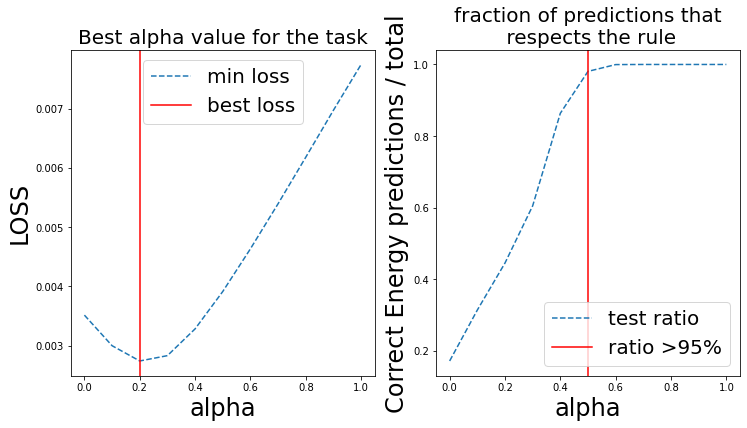

In [22]:
# select the best alpha and reconstruct a trajectory
best_loss = alphas[val_vs_a.argmin()] # best Loss
best_physics = alphas[(test_ratio_vs_a>0.95).argmax()] # Good Enercy dissipation

fig, ax = plt.subplots(1,2,figsize=[12, 6])
ax[0].plot(alphas,val_vs_a,"--",label = "min loss")
ax[0].set_ylabel('LOSS', fontsize=24)
ax[0].set_xlabel('alpha', fontsize=24)
ax[0].set_title("Best alpha value for the task",fontsize=20)
ax[0].axvline(best_loss, color='red',label="best loss")
ax[0].legend(fontsize=20)

ax[1].plot(alphas,test_ratio_vs_a,"--",label = "test ratio")
ax[1].axvline(best_physics, color='red',label="ratio >95%")
ax[1].legend(fontsize=20)
ax[1].set_ylabel('Correct Energy predictions / total', fontsize=24)
ax[1].set_xlabel('alpha', fontsize=24)
ax[1].set_title("fraction of predictions that\n respects the rule",fontsize=20)
ax[1].legend(fontsize=20)

In [23]:
test_trajectory=[]
reconstructed_trajectory=[]
alphazero_trajectory=[]
energy_trajectory=[]
model_eval.eval()
with torch.no_grad():        
    for test_x, test_y in test_loader:
        output_best_loss = model_eval(test_x, alpha=best_loss)
        output_best_energy = model_eval(test_x, alpha=best_physics)
        output_0 = model_eval(test_x, alpha=0)
        test_trajectory.append(test_y.cpu().numpy())
        reconstructed_trajectory.append(output_best_loss.cpu().numpy())
        alphazero_trajectory.append(output_0.cpu().numpy())
        energy_trajectory.append(output_best_energy.cpu().numpy())

In [24]:
reconstructed_trajectory=np.squeeze(np.array(reconstructed_trajectory))
test_trajectory=np.squeeze(np.array(test_trajectory))
alphazero_trajectory=np.squeeze(np.array(alphazero_trajectory))
energy_trajectory=np.squeeze(np.array(energy_trajectory))
reconstructed_trajectory.shape

(6000, 4)

Text(0.5, 0, 'time (s)')

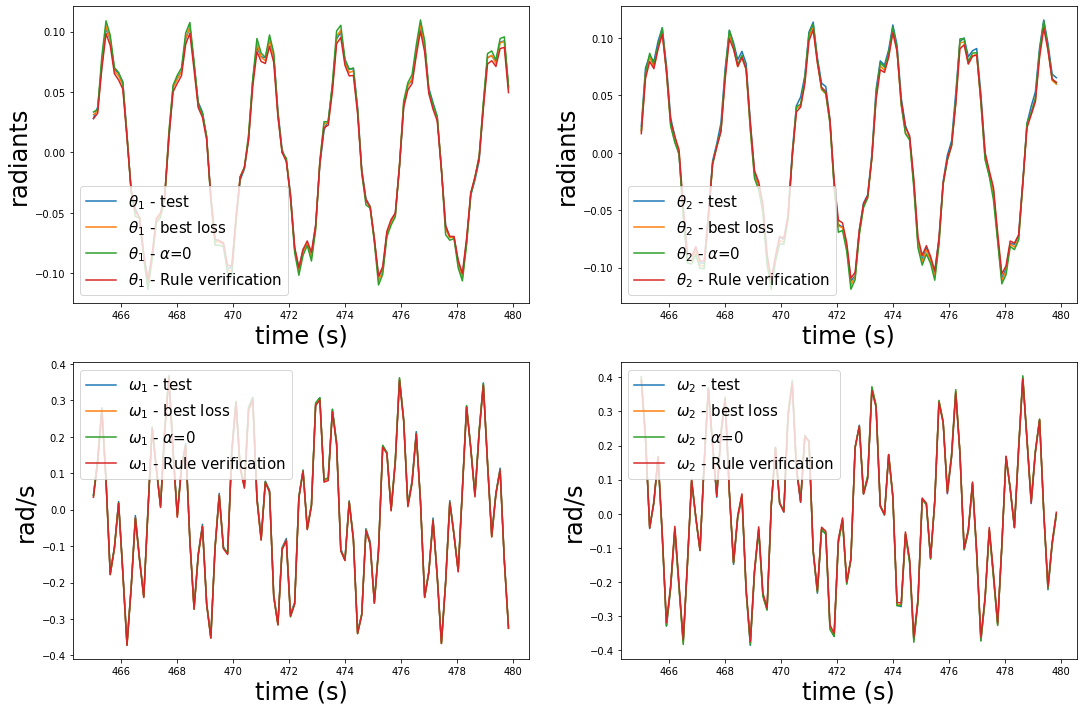

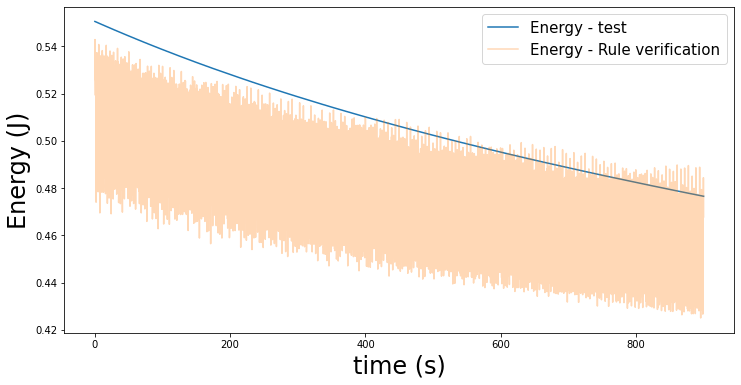

In [28]:
x_time = np.arange(test_trajectory.shape[0])*sampling_dt
fig, ax = plt.subplots(2,2,figsize=[18, 12])
ax[0,0].plot(x_time[3100:3200],test_trajectory[3100:3200,0],label = r"$\theta_1$ - test")
ax[0,0].plot(x_time[3100:3200],reconstructed_trajectory[3100:3200,0],label = r"$\theta_1$ - best loss")
ax[0,0].plot(x_time[3100:3200],alphazero_trajectory[3100:3200,0],label = r"$\theta_1$ - $\alpha$=0")
ax[0,0].plot(x_time[3100:3200],energy_trajectory[3100:3200,0],label = r"$\theta_1$ - Rule verification")
ax[0,0].legend(fontsize=15)
ax[0,0].set_ylabel('radiants', fontsize=24)
ax[0,0].set_xlabel('time (s)', fontsize=24)

ax[0,1].plot(x_time[3100:3200],test_trajectory[3100:3200,2],label = r"$\theta_2$ - test")
ax[0,1].plot(x_time[3100:3200],reconstructed_trajectory[3100:3200,2],label = r"$\theta_2$ - best loss")
ax[0,1].plot(x_time[3100:3200],alphazero_trajectory[3100:3200,2],label = r"$\theta_2$ - $\alpha$=0")
ax[0,1].plot(x_time[3100:3200],energy_trajectory[3100:3200,2],label = r"$\theta_2$ - Rule verification")
ax[0,1].legend(fontsize=15)
ax[0,1].set_ylabel('radiants', fontsize=24)
ax[0,1].set_xlabel('time (s)', fontsize=24)

ax[1,0].plot(x_time[3100:3200],test_trajectory[3100:3200,1],label = r"$\omega_1$ - test")
ax[1,0].plot(x_time[3100:3200],reconstructed_trajectory[3100:3200,1],label = r"$\omega_1$ - best loss")
ax[1,0].plot(x_time[3100:3200],alphazero_trajectory[3100:3200,1],label = r"$\omega_1$ - $\alpha$=0")
ax[1,0].plot(x_time[3100:3200],energy_trajectory[3100:3200,1],label = r"$\omega_1$ - Rule verification")
ax[1,0].legend(fontsize=15)
ax[1,0].set_ylabel('rad/s', fontsize=24)
ax[1,0].set_xlabel('time (s)', fontsize=24)


ax[1,1].plot(x_time[3100:3200],test_trajectory[3100:3200,3],label = r"$\omega_2$ - test")
ax[1,1].plot(x_time[3100:3200],reconstructed_trajectory[3100:3200,3],label = r"$\omega_2$ - best loss")
ax[1,1].plot(x_time[3100:3200],alphazero_trajectory[3100:3200,3],label = r"$\omega_2$ - $\alpha$=0")
ax[1,1].plot(x_time[3100:3200],energy_trajectory[3100:3200,3],label = r"$\omega_2$ - Rule verification")
ax[1,1].legend(fontsize=15)
ax[1,1].set_ylabel('rad/s', fontsize=24)
ax[1,1].set_xlabel('time (s)', fontsize=24)






_, _, real_E = calc_double_E(test_trajectory, **dp_params)
_, _, pred_E_loss = calc_double_E(reconstructed_trajectory, **dp_params)
_, _, pred_E_0 = calc_double_E(alphazero_trajectory, **dp_params)
_, _, pred_E_energy = calc_double_E(energy_trajectory, **dp_params)

fig, ax = plt.subplots(figsize=[12, 6])
ax.plot(x_time,real_E,label = "Energy - test",alpha = 1)
#ax.plot(x_time,pred_E_loss,label = "Energy - Best loss",alpha = 0.3)
ax.plot(x_time,pred_E_energy,label = "Energy - Rule verification",alpha = 0.3)
#ax.plot(x_time,pred_E_0,label = r"Energy - $\alpha =0$",alpha = 0.3)

plt.legend(fontsize=15)
ax.set_ylabel('Energy (J)', fontsize=24)
ax.set_xlabel('time (s)', fontsize=24)
#ax.set_xlim([200,240])